In [2]:
# File location and type
# Download from https://www.kaggle.com/arjunbhasin2013/ccdata/downloads/ccdata.zip/1
file_location = "./data/credit.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df.show(5)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
CUST_ID| BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT| PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
 C10001| 40.900749| 0.818182| 95.4| 0.0| 95.4| 0.0| 0.166667| 0.0| 0.083333| 0.0| 0| 2| 1000.0| 201.802084| 139.509787| 0.0| 12|
 C10002|3202.467416| 0.909091| 0.0| 0.0| 0.0| 6442.945483| 0.0| 0.0| 0.0| 0.25| 4| 0| 7000.0|4103.032597| 1072.340217| 0.222222| 12|
 C10003|2495.148862| 1.0| 773.17| 773.17| 0.0| 0.0| 1.0| 1.0| 0.0| 0.0| 0| 12| 7500.0| 622.066742| 627.284787| 0.0| 12|
 C10004|1666.670542| 0.636364| 1499.0| 1499.0| 0.0| 205.788017| 0.083333| 0.083333| 0.0| 0.083333| 1| 1| 7500.0| 0.0| null| 0.0| 12|
 C10005| 817.714335| 1.0| 16.0| 16.0| 0.0| 0.0| 0.083333| 0.083333| 0.0| 0.0| 0| 1| 1200.0| 678.334763| 244.791237| 0.0| 12|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
only showing top 5 rows

In [3]:
#Remove Null Values
ndf = df.dropna()

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-4239327777720598> in <module> () 
 1 ndf = df . dropna ( ) 
 ----> 2 ndf . isnull ( ) . sum ( ) 

 /databricks/spark/python/pyspark/sql/dataframe.py in __getattr__ (self, name) 
 1323 if name not in self . columns : 
 1324 raise AttributeError(
 -> 1325 "'%s' object has no attribute '%s'" % (self.__class__.__name__, name))
 1326 jc = self . _jdf . apply ( name ) 
 1327 return Column ( jc ) 

 AttributeError : 'DataFrame' object has no attribute 'isnull'

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

In [5]:
for col in ndf.columns:
    if col != 'CUST_ID':
        ndf = ndf.withColumn(col,ndf[col].cast('float'))

In [6]:
temp = list(ndf.columns)
FEAT = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

In [7]:
vecAssembler = VectorAssembler(inputCols=FEAT, outputCol="features")
df_kmeans = vecAssembler.transform(ndf).select('features')
df_kmeans.show()

+--------------------+
 features|
+--------------------+
[40.9007492065429...|
(17,[0,1,5,9,10,1...|
[2495.14892578125...|
[817.71435546875,...|
[1809.82873535156...|
[627.260803222656...|
[1823.65270996093...|
[1014.92645263671...|
[152.225967407226...|
[1293.125,1.0,920...|
[630.794738769531...|
[1516.92858886718...|
[921.693359375,1....|
(17,[0,1,5,9,10,1...|
[6886.21337890625...|
(17,[0,1,5,9,10,1...|
[41.0894889831543...|
[1989.072265625,1...|
[3577.97094726562...|
[2016.68469238281...|
+--------------------+
only showing top 20 rows

In [8]:
#compute cost of all Ks
cost = np.zeros(30)
for k in range(2,29):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

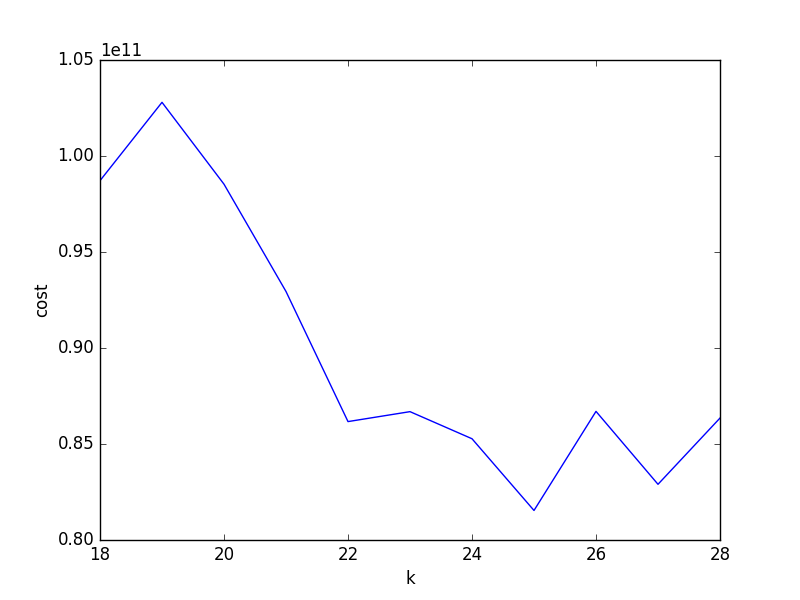

In [9]:
#plot cost of all Ks
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,29),cost[2:29])
ax.set_xlabel('k')
ax.set_ylabel('cost')
display()

In [10]:
#use the best k
k = 25
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 4.02945672e+03 9.53846334e-01 8.74245375e+02 5.17689479e+02
 3.56555897e+02 5.75155362e+03 3.94026851e-01 1.93093202e-01
 2.92642305e-01 4.40063201e-01 1.44179104e+01 1.58208955e+01
 8.37316825e+03 7.92787209e+03 1.42116531e+03 7.22830071e-02
 1.17014925e+01]
[ 1.04929250e+04 9.99011859e-01 2.17892141e+03 1.20476968e+03
 9.74879457e+02 2.13434467e+03 5.79347825e-01 3.11347142e-01
 4.96508587e-01 2.63026988e-01 5.91304348e+00 3.17500000e+01
 1.53527174e+04 3.35333250e+03 3.35126262e+03 0.00000000e+00
 1.18369565e+01]
[ 6.50576080e+02 8.79138911e-01 3.11377458e+02 1.28350763e+02
 1.83425113e+02 2.64527399e+02 4.31874216e-01 9.33618121e-02
 3.39282849e-01 9.92311078e-02 1.79055690e+00 7.24899112e+00
 1.35165591e+03 5.43578775e+02 3.78227305e+02 1.27384418e-01
 1.11698951e+01]
[ 5.65853425e+03 9.65009498e-01 8.43482507e+02 5.41586868e+02
 3.01895627e+02 1.24296103e+04 2.81498000e-01 1.28224208e-01
 2.18253958e-01 6.04360586e-01 2.44583333e+01 9.18750000e+00
 1.01812500e+04 1.16132878e+04 2.07005930e+03 8.70550214e-02
 1.16458333e+01]
[ 7.08542192e+03 1.00000000e+00 4.08329102e+04 3.47640797e+04
 6.06883018e+03 1.11633374e+02 9.66666603e-01 9.33333397e-01
 8.33333403e-01 1.66666001e-02 2.00000000e-01 2.31000000e+02
 1.75000000e+04 3.63464730e+04 4.21501975e+03 6.16666600e-01
 1.20000000e+01]
[ 3.82024552e+03 6.43738887e-01 1.84774887e+03 1.11713482e+03
 7.31428893e+02 4.79812040e+03 4.07126814e-01 2.58978630e-01
 3.01346850e-01 2.51523187e-01 9.37037037e+00 2.27037037e+01
 1.17185185e+04 1.96497242e+04 1.62595867e+03 2.63804628e-01
 1.15555556e+01]
[ 4.75849341e+03 6.36363506e-01 9.86691998e+03 8.97250000e+03
 8.94419983e+02 4.50156021e+01 5.83333500e-01 8.33334997e-02
 5.00000000e-01 4.16665003e-02 5.00000000e-01 7.50000000e+00
 1.80000000e+04 4.56745391e+04 1.64986865e+03 8.33334997e-02
 1.20000000e+01]
[ 7.84492891e+02 8.87960755e-01 1.29228787e+03 6.95927784e+02
 5.96360080e+02 7.75531468e+02 5.78243475e-01 2.81759429e-01
 4.13165383e-01 1.39404963e-01 3.31897927e+00 1.84433812e+01
 2.06831473e+03 2.43926448e+03 5.92791179e+02 2.09329990e-01
 1.16283892e+01]
[ 1.77434130e+03 8.63697237e-01 5.02440000e+02 2.63761293e+02
 2.38838710e+02 3.17937816e+03 2.96838502e-01 1.35289838e-01
 1.92375360e-01 3.19438613e-01 9.44700461e+00 7.98156682e+00
 4.35791091e+03 5.50657726e+03 8.72600376e+02 1.58308000e-01
 1.17096774e+01]
[ 3.08147002e+03 9.27730601e-01 3.68603871e+02 2.15637808e+02
 1.52966061e+02 4.29149634e+03 2.60658295e-01 1.11938222e-01
 1.74892141e-01 4.19952078e-01 1.16643836e+01 6.40410959e+00
 6.13236301e+03 1.45422042e+03 1.02499766e+03 1.22740240e-02
 1.09349315e+01]
[ 1.19075887e+03 9.59158085e-01 5.43801732e+03 3.92184023e+03
 1.51964532e+03 3.36720059e+02 8.97982733e-01 7.19828340e-01
 6.48172492e-01 5.11472830e-02 1.46242775e+00 6.02485549e+01
 5.27601156e+03 5.55063855e+03 6.74671643e+02 4.20103977e-01
 1.19190751e+01]
[ 6.93624937e+03 9.76617786e-01 4.92873422e+02 2.75265722e+02
 2.17607702e+02 5.85536681e+03 3.03995823e-01 1.27168502e-01
 2.21070754e-01 4.62701721e-01 1.41764706e+01 8.98395722e+00
 1.06505348e+04 2.13309452e+03 2.26850565e+03 6.68449198e-04
 1.14652406e+01]
[ 1.11282304e+03 8.56951639e-01 2.00906285e+03 1.29184821e+03
 7.17214637e+02 3.98167139e+02 7.22838130e-01 4.66789853e-01
 4.72172968e-01 5.23527726e-02 9.91869919e-01 2.58699187e+01
 1.60691057e+04 2.65958202e+03 3.83640127e+02 4.36179161e-01
 1.18536585e+01]
[ 5.21251295e+03 9.83422469e-01 2.47041899e+04 1.89637548e+04
 5.74043528e+03 1.27966905e+03 9.30392116e-01 8.65686292e-01
 7.13725413e-01 4.90195874e-02 2.35294118e+00 1.05352941e+02
 1.55000000e+04 2.38860566e+04 3.21921608e+03 5.15819940e-01
 1.18823529e+01]
[ 4.32081132e+03 9.92691200e-01 5.03376549e+03 3.45775522e+03
 1.57601028e+03 6.28874466e+02 9.07499993e-01 6.78820364e-01
 6.79653692e-01 8.14033004e-02 1.94285714e+00 6.02714286e+01
 1.00050000e+04 3.51528067e+03 1.68288644e+03 6.95237789e-02
 1.18285714e+01]
[ 3.29820203e+03 9.82565396e-01 1.06730133e+04 6.840